In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [23]:
def to_hours(time):
    return (time // 3600) + 6

def clean_sales_data():
    df = pd.read_csv("../assets/example_data/sales_data.csv")
    sales_df = df[['token_id', 'sold_at', 'price']]
    sales_df = sales_df.rename(columns={'token_id': 'horse_id', 'sold_at': 'time_sold'}).sort_values('horse_id').reset_index(drop=True)
    sales_df['timestamp'] = sales_df['time_sold'].apply(to_hours)

    return sales_df

In [24]:
sales_data = clean_sales_data()

In [25]:
eth_prices = pd.read_csv('../assets/eth_price_history.csv')
eth_prices.tail()

,Unnamed: 0,timestamp,eth_price
9091,9091,464923,1533.01
9092,9092,464924,1529.65
9093,9093,464925,1535.38
9094,9094,464926,1538.76
9095,9095,464927,1550.97


In [26]:
merged = pd.merge(sales_data, eth_prices, left_on='timestamp', right_on='timestamp', how='left')
merged['converted_price'] = merged['price'] * merged['eth_price']
clean_market_data = merged.drop(columns=['Unnamed: 0', 'price', 'timestamp','eth_price'])
clean_market_data.shape

def to_day(unix_time):
    return datetime.date.fromtimestamp(unix_time)

clean_market_data['day_sold'] = clean_market_data['time_sold'].apply(to_day)
clean_market_data

,horse_id,time_sold,converted_price,day_sold
0,27,1650124789,60665.000,2022-04-16
1,68,1657313128,13934.205,2022-07-08
2,75,1657313072,9693.360,2022-07-08
3,89,1657313100,9693.360,2022-07-08
4,92,1663112422,10943.775,2022-09-13
...,...,...,...,...
74906,520344,1673482196,139.492,2023-01-11
74907,520345,1673514341,138.079,2023-01-12
74908,520346,1673487400,139.884,2023-01-11
74909,520404,1673622818,499.436,2023-01-13


### Deal with outliers

In [27]:
# Calculate the z-score for each data point
clean_market_data['z_score'] = np.abs((clean_market_data['converted_price'] - np.mean(clean_market_data['converted_price'])) / np.std(clean_market_data['converted_price']))

clean_market_data
market_data_no_outliers = clean_market_data[clean_market_data['z_score'] < 3]
print(clean_market_data.shape, market_data_no_outliers.shape, f'=> {74911 - 74820} data points removed')

(74911, 5) (74820, 5) => 91 data points removed


In [376]:
# horse data cleaning
horse_data = pd.read_csv('../assets/all_horse_meta_small_sample.csv')
horse_data.columns
horse_data = horse_data.rename(columns={'data.horse.bloodline':'bloodline', 'data.horse.breed_type':'breed_type',
                           'data.horse.breeding_counter':'breeding_counter', 'data.horse.color':'horse_color',
                           'data.horse.horse_type':'horse_type', 'data.horse.img_url':'img_url',
                           'data.horse.last_breeding_reset':'last_breeding_reset', 'data.horse.name':'horse_name',
                           'data.horse.nft_id':'nft_id', 'data_horse_offsprings':'offsprings',
                           'data.horse.race_statistic.first_place_finishes':'first_place_finishes',
                           'data.horse.race_statistic.number_of_races':'number_races',
       'data.horse.race_statistic.second_place_finishes':'second_place_finishes',
       'data.horse.race_statistic.third_place_finishes':'third_place_finishes',
       'data.horse.race_statistic.win_rate':'win_rate',
                                        'data.horse.gen':'genotype'})
horse_data = horse_data.drop(columns=['Unnamed: 0'])
# print(horse_data.nft_id)
horse_data.head()

,bloodline,breed_type,horse_color,genotype,horse_type,img_url,data.horse.inserted_at,horse_name,nft_id,data.horse.parents,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat
0,Buterin,elite,Banana Mania,Z23,Filly,https://img.zed.run/horses/FAE7B5.png,2022-04-15T08:19:30,Considerable Threat,393229,"[{'name': 'Wicked Wanderer', 'nft_id': 174247}...",1,1.35,74,1,75,0.00,5,9,1.33,False
1,Nakamoto,exclusive,Fandango,Z5,Colt,https://img.zed.run/horses/B53389.png,2022-04-15T08:36:23,Nakuza,393233,"[{'name': 'Luchini', 'nft_id': 213835}, {'name...",6,4.58,131,0,131,0.00,15,12,4.58,False
2,Finney,legendary,Air Superiority Blue,Z7,Stallion,https://img.zed.run/horses/72A0C1.png,2021-10-17T06:37:21,Glorified Liberty,131092,"[{'name': 'Liberty Rules', 'nft_id': 13935}, {...",5,7.69,65,0,65,0.00,7,8,7.69,False
3,Nakamoto,exclusive,Battle Horse Gray,Z6,Colt,https://img.zed.run/horses/848482.png,2021-10-17T06:37:43,Glorified Ecstasy,131093,"[{'name': 'Ecstasy Jelly', 'nft_id': 81807}, {...",12,7.87,127,24,151,8.33,9,15,7.95,False
4,Buterin,elite,Eminence,Z16,Colt,https://img.zed.run/horses/6C3082.png,2022-04-15T08:51:24,System America,393237,"[{'name': 'How To', 'nft_id': 184177}, {'name'...",0,0.00,11,0,11,0.00,0,1,0.00,False


In [28]:
# code to merge horse data with sales data
test_merge = pd.merge(horse_data,market_data_no_outliers, right_on='horse_id', left_on='nft_id', how='left')
test_merge

,bloodline,breed_type,horse_color,genotype,horse_type,img_url,data.horse.inserted_at,horse_name,nft_id,data.horse.parents,...,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,day_sold,z_score
0,Buterin,elite,Banana Mania,Z23,Filly,https://img.zed.run/horses/FAE7B5.png,2022-04-15T08:19:30,Considerable Threat,393229,"[{'name': 'Wicked Wanderer', 'nft_id': 174247}...",...,0.00,5,9,1.33,False,393229,1650351817,7.961694,2022-04-19,0.025828
1,Nakamoto,exclusive,Fandango,Z5,Colt,https://img.zed.run/horses/B53389.png,2022-04-15T08:36:23,Nakuza,393233,"[{'name': 'Luchini', 'nft_id': 213835}, {'name...",...,0.00,15,12,4.58,False,393233,1656900551,34.636140,2022-07-03,0.025687
2,Finney,legendary,Air Superiority Blue,Z7,Stallion,https://img.zed.run/horses/72A0C1.png,2021-10-17T06:37:21,Glorified Liberty,131092,"[{'name': 'Liberty Rules', 'nft_id': 13935}, {...",...,0.00,7,8,7.69,False,131092,1657674585,42.426400,2022-07-12,0.025646
3,Nakamoto,exclusive,Battle Horse Gray,Z6,Colt,https://img.zed.run/horses/848482.png,2021-10-17T06:37:43,Glorified Ecstasy,131093,"[{'name': 'Ecstasy Jelly', 'nft_id': 81807}, {...",...,8.33,9,15,7.95,False,131093,1662355015,46.862100,2022-09-05,0.025622
4,Buterin,elite,Eminence,Z16,Colt,https://img.zed.run/horses/6C3082.png,2022-04-15T08:51:24,System America,393237,"[{'name': 'How To', 'nft_id': 184177}, {'name'...",...,0.00,0,1,0.00,False,393237,1657914163,5.941544,2022-07-15,0.025839
5,Nakamoto,genesis,Absolute Zero,Z1,Mare,https://img.zed.run/horses/0048BA.png,2019-01-31T03:49:18,Troubled Paradise,27,[],...,8.20,254,237,12.41,False,27,1650124789,60665.000000,2022-04-16,0.295651
6,Buterin,exclusive,Feldgrau,Z28,Filly,https://img.zed.run/horses/4D5D53.png,2021-10-17T06:51:45,Boron Metalloid,131100,"[{'name': 'Iced Caramel Macchiato', 'nft_id': ...",...,0.00,0,0,0.00,False,131100,1659166820,5.162580,2022-07-30,0.025843


## Exploratory Data Analysis

### Price Distribution

<AxesSubplot: xlabel='converted_price'>

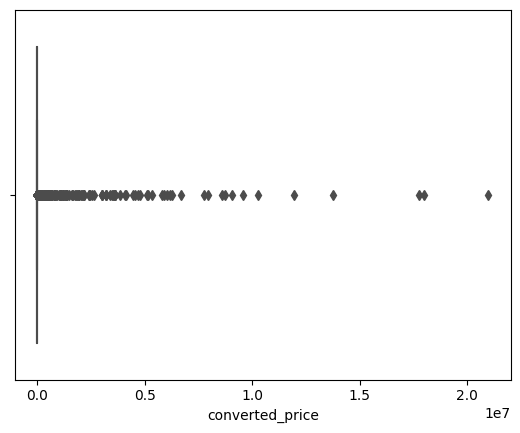

In [29]:
sns.boxplot(data = clean_market_data, x='converted_price', color='red')
# plt.xlim(0,20000)
# plt.ylim(0,80)

The distribution of prices is highly right skewed.

### Win rate vs Price

<AxesSubplot: xlabel='win_rate', ylabel='converted_price'>

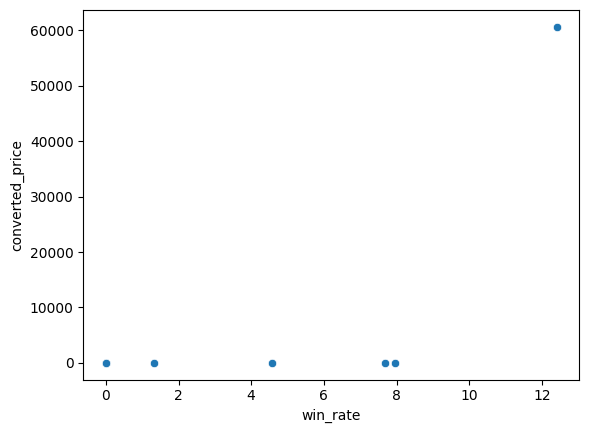

In [30]:
sns.scatterplot(data=test_merge, x='win_rate', y='converted_price')

### Different Factors by Breed

In [31]:
by_breed = test_merge.groupby('breed_type').mean().reset_index()
by_breed

/var/folders/ys/99fy7jvd78ldkj5yxhg35plh0000gn/T/ipykernel_6343/2082808561.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_breed = test_merge.groupby('breed_type').mean().reset_index()


,breed_type,nft_id,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,z_score
0,elite,393233.000000,0.5,0.675,42.500000,0.5,43.000000,0.000000,2.5,5.0,0.665000,0.0,393233.000000,1.654133e+09,6.951619,0.025834
1,exclusive,218475.333333,6.0,4.150,89.333333,8.0,97.333333,2.776667,8.0,9.0,4.176667,0.0,218475.333333,1.659474e+09,28.886940,0.025718
2,genesis,27.000000,226.0,18.610,736.000000,1085.0,1821.000000,8.200000,254.0,237.0,12.410000,0.0,27.000000,1.650125e+09,60665.000000,0.295651
3,legendary,131092.000000,5.0,7.690,65.000000,0.0,65.000000,0.000000,7.0,8.0,7.690000,0.0,131092.000000,1.657675e+09,42.426400,0.025646


Text(0.5, 1.0, 'Mean Win Rate by Breed Type')

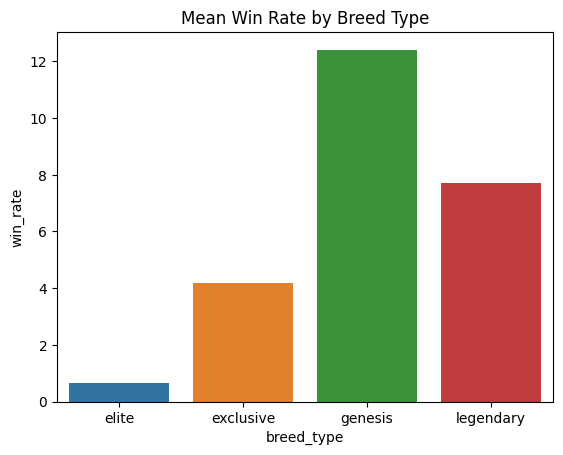

In [32]:
sns.barplot(data=by_breed, x='breed_type', y='win_rate')
plt.title('Mean Win Rate by Breed Type')

Text(0.5, 1.0, 'Mean Number of 1st Place Finishes by Breed')

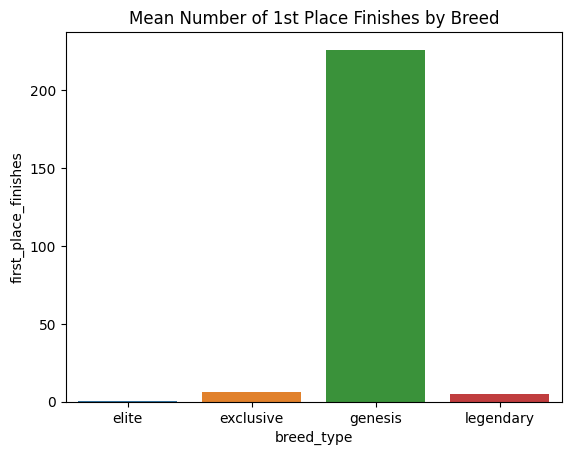

In [33]:
sns.barplot(data=by_breed, x='breed_type', y='first_place_finishes')
plt.title('Mean Number of 1st Place Finishes by Breed')

<AxesSubplot: xlabel='breed_type', ylabel='converted_price'>

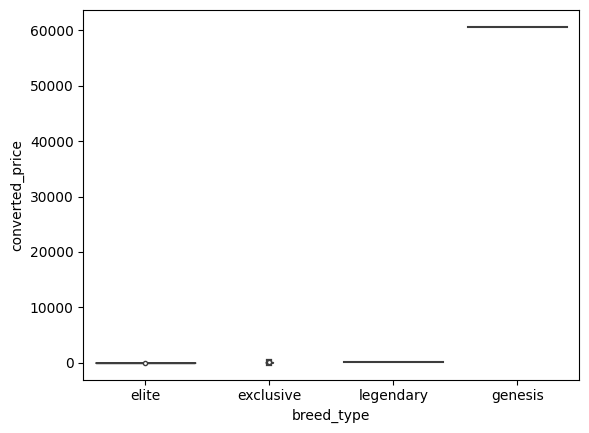

In [34]:
sns.violinplot(data=test_merge, x='breed_type', y='converted_price')

### Different Factors by Bloodline

In [35]:
by_blood = test_merge.groupby('bloodline').mean().reset_index()
by_blood

/var/folders/ys/99fy7jvd78ldkj5yxhg35plh0000gn/T/ipykernel_6343/1323334638.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_blood = test_merge.groupby('bloodline').mean().reset_index()


,bloodline,nft_id,first_place_finishes,data.horse.race_statistic.free_win_rate,data.horse.race_statistic.number_of_free_races,data.horse.race_statistic.number_of_paid_races,number_races,data.horse.race_statistic.paid_win_rate,second_place_finishes,third_place_finishes,win_rate,data.horse.super_coat,horse_id,time_sold,converted_price,z_score
0,Buterin,305855.333333,0.333333,0.450000,31.666667,0.333333,32.0,0.00,1.666667,3.333333,0.443333,0.0,305855.333333,1.655811e+09,6.355273,0.025837
1,Finney,131092.000000,5.000000,7.690000,65.000000,0.000000,65.0,0.00,7.000000,8.000000,7.690000,0.0,131092.000000,1.657675e+09,42.426400,0.025646
2,Nakamoto,174784.333333,81.333333,10.353333,331.333333,369.666667,701.0,5.51,92.666667,88.000000,8.313333,0.0,174784.333333,1.656460e+09,20248.832747,0.115653


(array([0, 1, 2]),
 [Text(0, 0, 'Buterin'), Text(1, 0, 'Finney'), Text(2, 0, 'Nakamoto')])

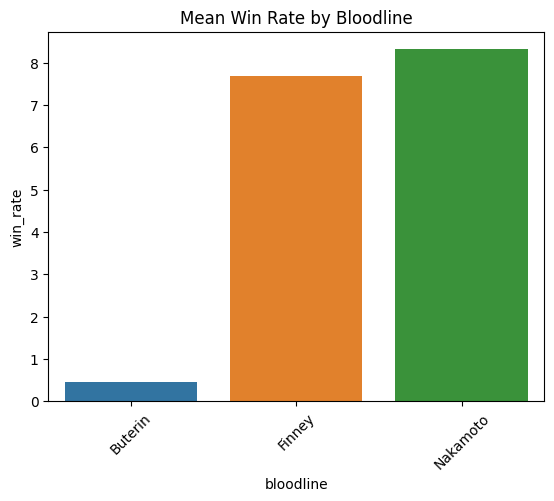

In [36]:
sns.barplot(data=by_blood, x='bloodline', y='win_rate')
plt.title('Mean Win Rate by Bloodline')
plt.xticks(rotation = 45)

<AxesSubplot: xlabel='day_sold', ylabel='converted_price'>

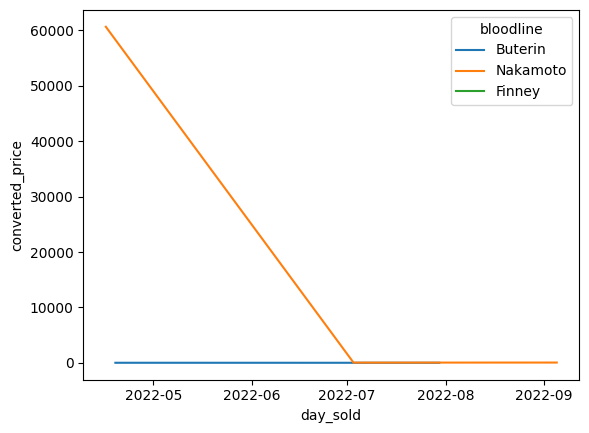

In [386]:
sns.lineplot(data=test_merge, x='day_sold', y='converted_price', hue= 'bloodline')